# Depedency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

os.environ['BIGSI_CONFIG'] = 'berkleydb.yaml'

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

In [2]:
!mccortex 31 2>&1 | grep version

version: mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31


In [3]:
!bigsi --version | grep bigsi-v

bigsi-v0.3.1


# Benchmarking

## Input data and constants

In [4]:
input_dir = '../data/input-files/reads'

input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

nproc=32
kmer=31

bigsi_dir = 'bigsi-data'
sample_sizes = [1,10,20,30,40,50,60,70,80]
#sample_sizes = [1, 10]

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS994', 'MOD1_LS995', 'MOD1_LS996', 'MOD1_LS997', 'MOD1_LS998', 'PNUSA000194', 'PNUSA000195', 'PNUSA000196', 'PNUSAL000730', 'PNUSAL000870', 'PNUSAL000957', 'PNUSAL001024', 'SIM_CFSAN000189', 'SIM_CFSAN000191', 'SIM_CFSAN000211', 'SIM_CFSAN000212', 'SIM_CFSAN000228', 'SIM_CFSAN000661', 'SIM_CFSAN000669', 'SIM_CFSAN000700', 'SIM_CFSAN000752', 'SIM_

## Benchmark functions

In [5]:
def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    benchmark.clean_if_exists(bigsi_dir)
    benchmark.clean_if_exists("test-berkeley.db")
    
def sampling_func(input_size):
    return input_samples[:input_size]

mccortex_command = {
    "command": f"mccortex 31 build --nkmers 100000000 --threads 1 --kmer {kmer} --mem 20G" \
        + f" --sample % --seq2 {input_dir}/%_1.fastq.gz:{input_dir}/%_2.fastq.gz {bigsi_dir}/%.ctx",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_bloom_command = {
    "command": f"bigsi bloom -c berkleydb.yaml {bigsi_dir}/%.ctx {bigsi_dir}/%.bloom",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) \
        + " " + " ".join(list(map(lambda sample_file: f"{bigsi_dir}/%s.bloom" % sample_file, sample_files))),
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

## Benchmark

In [6]:
multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
        "query": [query_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
parallel -j 32 -I% mccortex 31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample % --seq2 ../data/input-files/reads/%_1.fastq.gz:../data/input-files/reads/%_2.fastq.gz bigsi-data/%.ctx ::: 2014C-3598

STDOUT: 
-------------
STDERR: [06 Dec 2020 13:38:28-vux][cmd] /home/CSCScience.ca/apetkau/miniconda3/envs/thesis-benchmarking/bin/mccortex31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample 2014C-3598 --seq2 ../data/input-files/reads/2014C-3598_1.fastq.gz:../data/input-files/reads/2014C-3598_2.fastq.gz bigsi-data/2014C-3598.ctx
[06 Dec 2020 13:38:28-vux][cwd] /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/bigsi
[06 Dec 2020 13:38:28-vux][version] mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31
[06 Dec 2020 13:38:28-vux] Saving graph to: bigsi-data/2014C-3598.ctx
[06 Dec 2020 13:38:28-vux][sample] 0: 2014C-3598
[06 Dec 2020 13:38:28-vux][task] ../data/input-files/reads/2014C

# Save and reload results

In [7]:
save_path = "bigsi-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)
multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)
print(multibench_results)

[{'index': {'runtime': 1049.53, 'memory': 2987773952.0, 'disk_read': 153144628371.0, 'disk_write': 153216946906.0}, 'query': {'runtime': 1.32, 'memory': 86679552.0, 'disk_read': 19159333.0, 'disk_write': 621731.0}}, {'index': {'runtime': 1854.84, 'memory': 17434284032.0, 'disk_read': 153241619419.0, 'disk_write': 153294469071.0}, 'query': {'runtime': 1.41, 'memory': 86761472.0, 'disk_read': 19250268.0, 'disk_write': 633498.0}}, {'index': {'runtime': 1885.23, 'memory': 26552934400.0, 'disk_read': 153417929259.0, 'disk_write': 153433619807.0}, 'query': {'runtime': 1.52, 'memory': 87015424.0, 'disk_read': 19284720.0, 'disk_write': 642437.0}}, {'index': {'runtime': 2209.31, 'memory': 39805800448.0, 'disk_read': 10172796668.0, 'disk_write': 9923568068.0}, 'query': {'runtime': 1.3, 'memory': 85676032.0, 'disk_read': 17965640.0, 'disk_write': 625224.0}}, {'index': {'runtime': 2633.92, 'memory': 44172591104.0, 'disk_read': 14031560460.0, 'disk_write': 13699516174.0}, 'query': {'runtime': 1.22,

# Plot

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

[{'runtime': 1049.53, 'memory': 2987773952.0, 'disk_read': 153144628371.0, 'disk_write': 153216946906.0}, {'runtime': 1854.84, 'memory': 17434284032.0, 'disk_read': 153241619419.0, 'disk_write': 153294469071.0}, {'runtime': 1885.23, 'memory': 26552934400.0, 'disk_read': 153417929259.0, 'disk_write': 153433619807.0}, {'runtime': 2209.31, 'memory': 39805800448.0, 'disk_read': 10172796668.0, 'disk_write': 9923568068.0}, {'runtime': 2633.92, 'memory': 44172591104.0, 'disk_read': 14031560460.0, 'disk_write': 13699516174.0}, {'runtime': 2711.05, 'memory': 54721728512.0, 'disk_read': 17334401844.0, 'disk_write': 16919102184.0}, {'runtime': 2906.7, 'memory': 63367852032.0, 'disk_read': 20476933625.0, 'disk_write': 19978599323.0}, {'runtime': 3033.07, 'memory': 64670240768.0, 'disk_read': 24578034763.0, 'disk_write': 24573152525.0}, {'runtime': 3605.81, 'memory': 64710434816.0, 'disk_read': 29405426770.0, 'disk_write': 30023654264.0}]


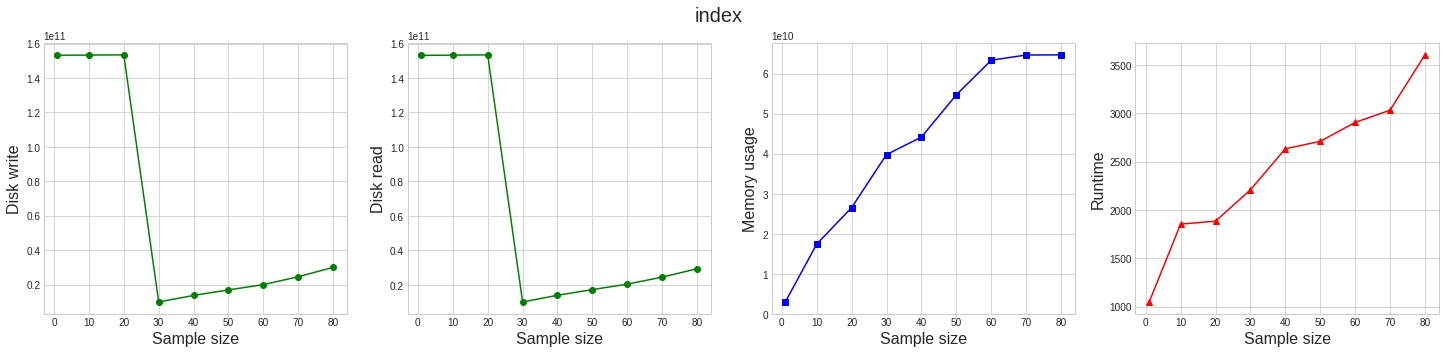

In [9]:
# Indexing Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 1.32, 'memory': 86679552.0, 'disk_read': 19159333.0, 'disk_write': 621731.0}, {'runtime': 1.41, 'memory': 86761472.0, 'disk_read': 19250268.0, 'disk_write': 633498.0}, {'runtime': 1.52, 'memory': 87015424.0, 'disk_read': 19284720.0, 'disk_write': 642437.0}, {'runtime': 1.3, 'memory': 85676032.0, 'disk_read': 17965640.0, 'disk_write': 625224.0}, {'runtime': 1.22, 'memory': 85757952.0, 'disk_read': 17964814.0, 'disk_write': 625224.0}, {'runtime': 1.29, 'memory': 85782528.0, 'disk_read': 17966765.0, 'disk_write': 633417.0}, {'runtime': 1.21, 'memory': 85942272.0, 'disk_read': 17965655.0, 'disk_write': 625224.0}, {'runtime': 1.28, 'memory': 85868544.0, 'disk_read': 17965787.0, 'disk_write': 625224.0}, {'runtime': 1.3, 'memory': 85745664.0, 'disk_read': 17966782.0, 'disk_write': 625224.0}]


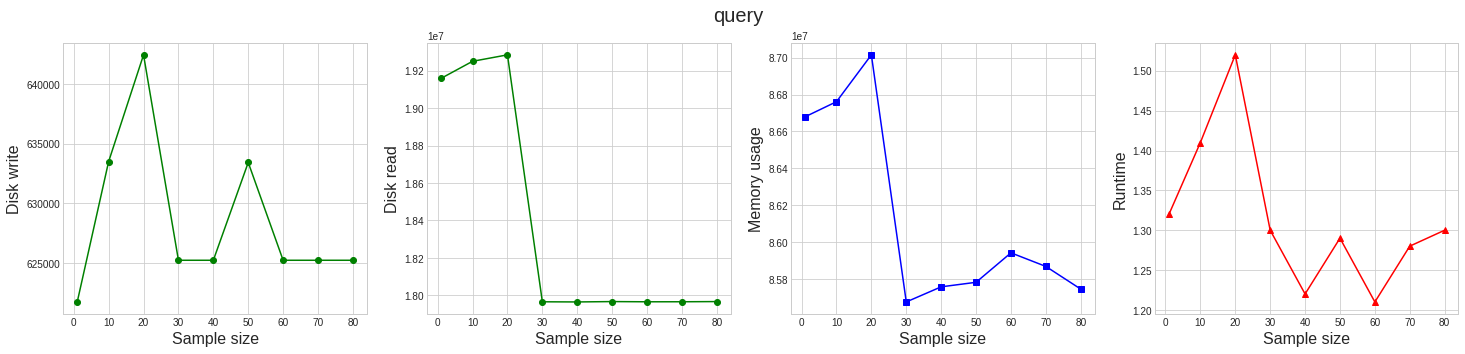

In [10]:
# Querying Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "query")